In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set the plotting style
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

In [3]:
# Load the dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Check data types and missing values
print("\nData Types and Missing Values:")
display(df.info())
display(df.isnull().sum())

Saving diabetes_prediction_dataset.csv to diabetes_prediction_dataset.csv
Dataset Shape: (100000, 9)

First 5 rows:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0



Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


None

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [4]:
# Data Preprocessing

# 1. Handle categorical variables
print("Preprocessing the dataset...")

# Handle gender
print("\nEncoding gender...")
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1, 'Other': 2})

# Handle smoking_history
print("\nEncoding smoking_history...")
smoking_map = {
    'never': 0,
    'No Info': 1,
    'current': 2,
    'former': 3,
    'ever': 4,
    'not current': 5
}
df['smoking_history'] = df['smoking_history'].map(smoking_map)

# 2. Check for missing values after encoding
print("\nMissing values after encoding:")
display(df.isnull().sum())

# 3. Check the processed dataset
print("\nProcessed dataset (first 5 rows):")
display(df.head())

# 4. Separate features and target
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)

Preprocessing the dataset...

Encoding gender...

Encoding smoking_history...

Missing values after encoding:


,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0



Processed dataset (first 5 rows):


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,2,23.45,5.0,155,0
4,1,76.0,1,1,2,20.14,4.8,155,0



Features shape: (100000, 8)
Target shape: (100000,)


Training set shape: (80000, 8)
Testing set shape: (20000, 8)

Class distribution in training set:
heart_disease
0    96.0575
1     3.9425
Name: proportion, dtype: float64

Class distribution in testing set:
heart_disease
0    96.06
1     3.94
Name: proportion, dtype: float64

Calculated scale_pos_weight: 24.3646

Training a simple XGBoost model with class balancing...

Model Evaluation:
Accuracy: 0.811

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     19212
           1       0.13      0.69      0.22       788

    accuracy                           0.81     20000
   macro avg       0.56      0.75      0.56     20000
weighted avg       0.95      0.81      0.87     20000



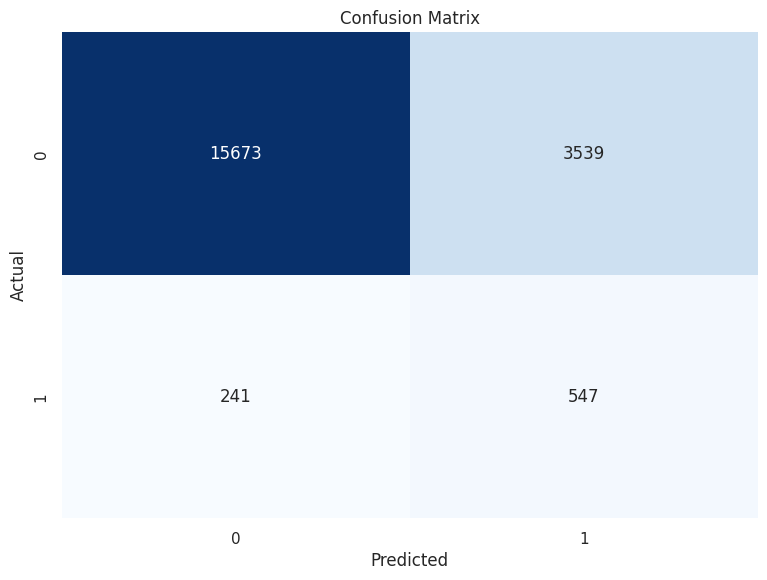

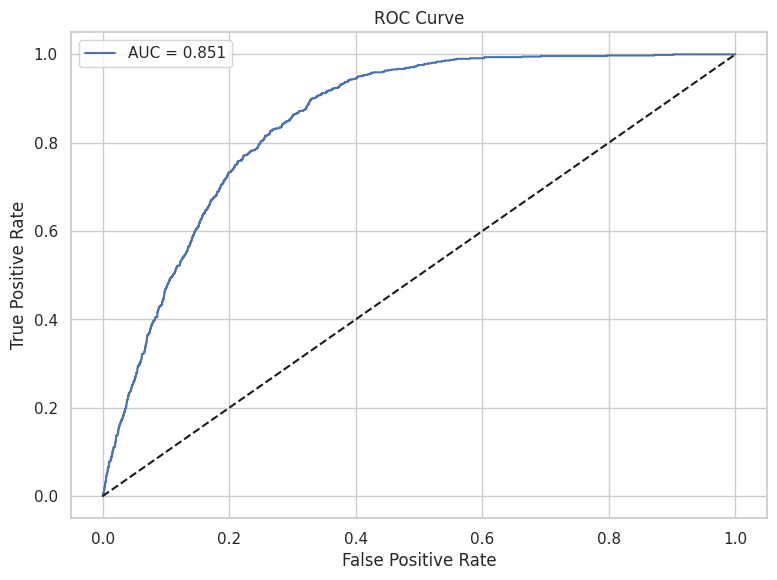

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Check class distribution in the splits
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

# Calculate class weight for imbalance
neg_class_count = sum(y_train == 0)
pos_class_count = sum(y_train == 1)
scale_pos_weight_value = neg_class_count / pos_class_count
print(f"\nCalculated scale_pos_weight: {scale_pos_weight_value:.4f}")

# Train a simple XGBoost model
print("\nTraining a simple XGBoost model with class balancing...")
model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_value  # Add weight for positive class to handle imbalance
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

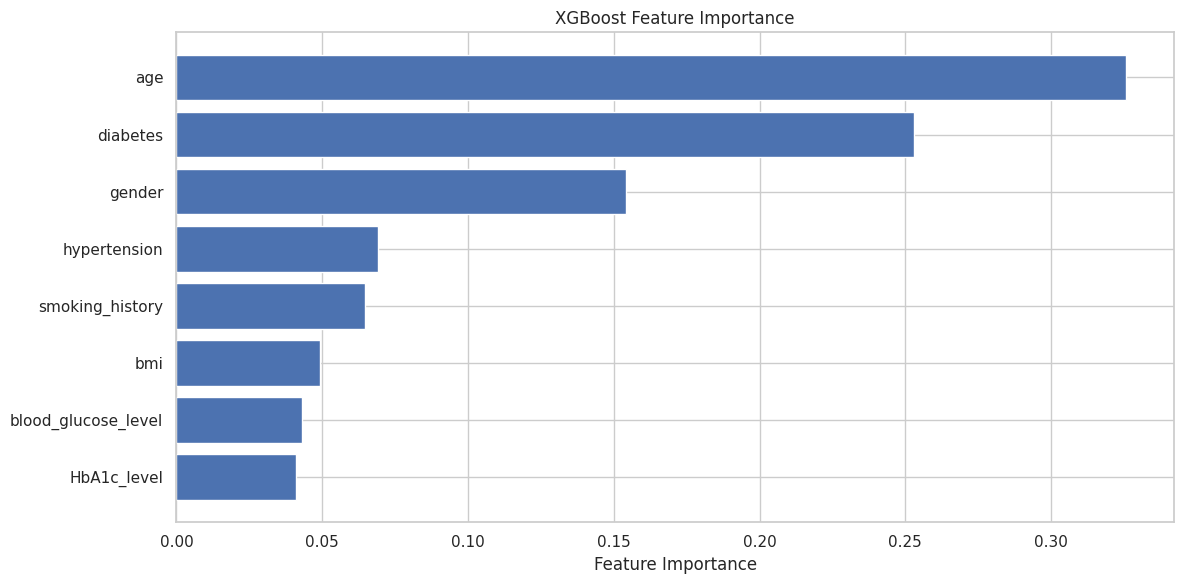


Top 5 Most Important Features:


,Feature,Importance
1,age,0.325842
7,diabetes,0.252863
0,gender,0.154254
2,hypertension,0.069166
3,smoking_history,0.064594


In [6]:
# Feature Importance Analysis
plt.figure(figsize=(12, 6))
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Display top 5 most important features
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 5 Most Important Features:")
display(feature_importance_df.head(5))

Performing hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best Parameters:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 24.364616360177553, 'subsample': 0.8}

Best Score (F1): 0.8779052946694837

Cross-validation results for different metrics:
auc: 0.8779 (±0.0002)
f1: 0.2128 (±0.0026)
recall: 0.8729 (±0.0122)
precision: 0.1212 (±0.0018)

Best Model Evaluation:
Accuracy: 0.7439

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     19212
           1       0.12      0.88      0.21       788

    accuracy                           0.74     20000
   macro avg       0.56      0.81      0.53     20000
weighted avg       0.96      0.74      0.82     20000



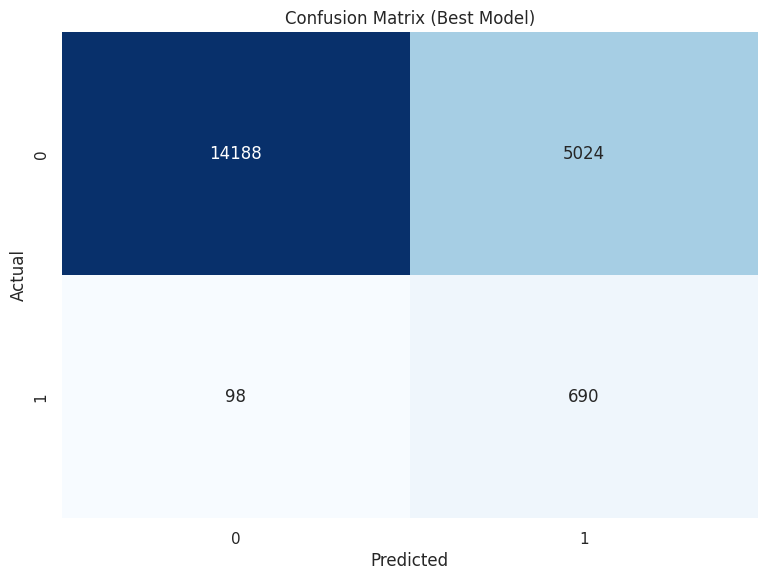

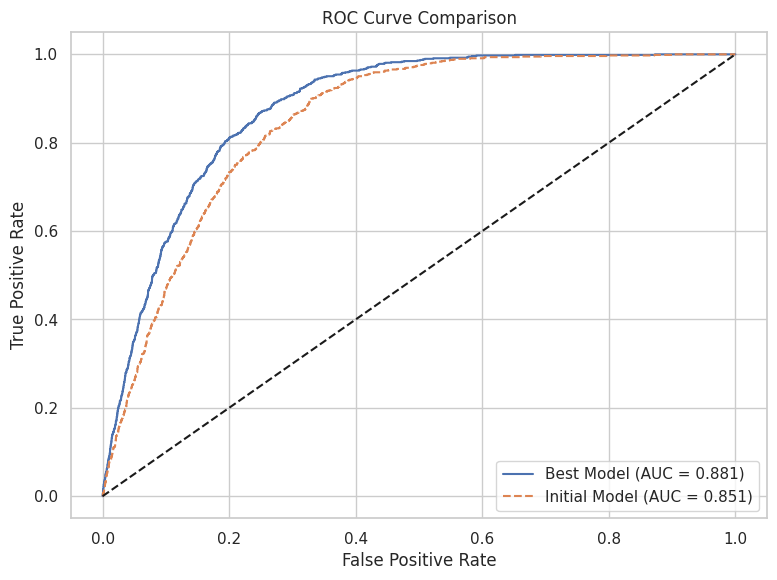

In [7]:
# Hyperparameter Tuning with GridSearchCV
print("Performing hyperparameter tuning with GridSearchCV...")

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'scale_pos_weight': [scale_pos_weight_value]
}

# Initialize the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric=['logloss', 'auc', 'error']  # Multiple metrics to evaluate
)

# Initialize GridSearchCV with balanced scoring metrics
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score

scoring = {
    'auc': 'roc_auc',
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score)
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='auc',
    cv=3,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest Parameters:")
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Print scores for different metrics
print("\nBest Score (F1):", grid_search.best_score_)
print("\nCross-validation results for different metrics:")
for metric in scoring.keys():
    mean_score = grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_]
    std_score = grid_search.cv_results_[f'std_test_{metric}'][grid_search.best_index_]
    print(f"{metric}: {mean_score:.4f} (±{std_score:.4f})")

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Evaluate the best model
print("\nBest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Plot confusion matrix for the best model
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for the best model
plt.figure(figsize=(8, 6))
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
auc_best = roc_auc_score(y_test, y_pred_proba_best)
plt.plot(fpr_best, tpr_best, label=f'Best Model (AUC = {auc_best:.3f})')
plt.plot(fpr, tpr, label=f'Initial Model (AUC = {auc:.3f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

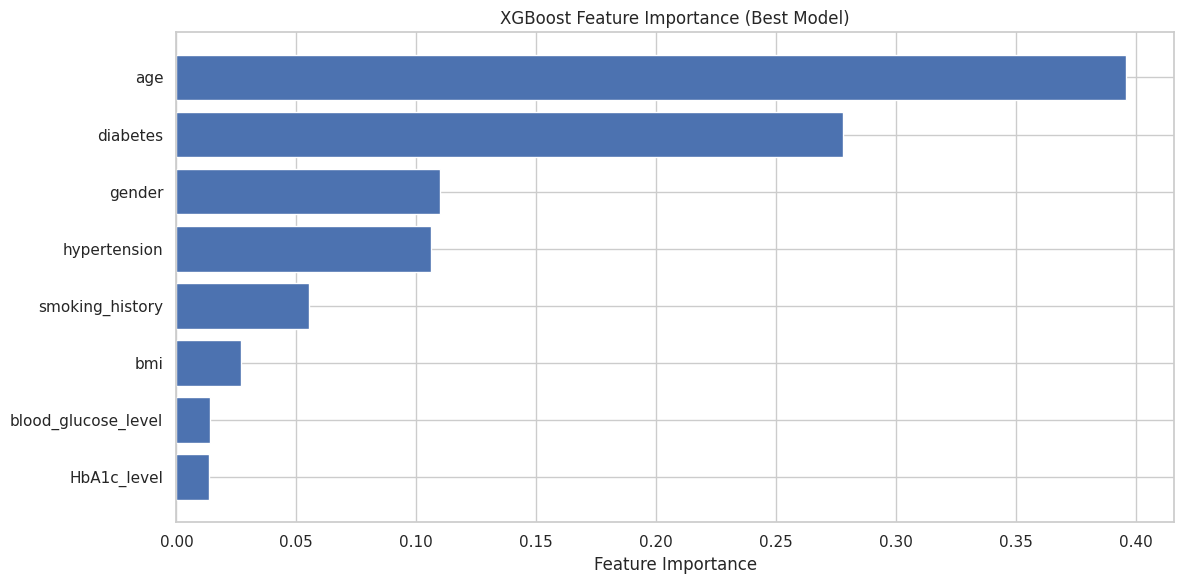


Top 5 Most Important Features (Best Model):


,Feature,Importance
1,age,0.396166
7,diabetes,0.278077
0,gender,0.109714
2,hypertension,0.106213
3,smoking_history,0.055467



Average Precision Score: 0.2001

Optimal Threshold: 0.7866
F1 Score at Optimal Threshold: 0.2919
Precision at Optimal Threshold: 0.2063
Recall at Optimal Threshold: 0.4987


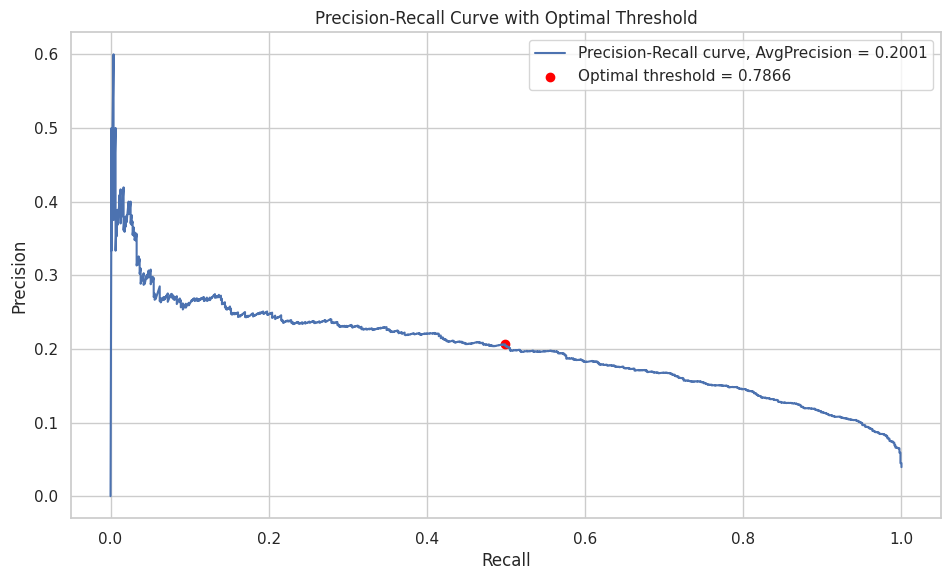


Model Evaluation with Optimal Threshold:
Accuracy: 0.90465
F1 Score: 0.29186780542146307

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     19212
           1       0.21      0.50      0.29       788

    accuracy                           0.90     20000
   macro avg       0.59      0.71      0.62     20000
weighted avg       0.95      0.90      0.92     20000



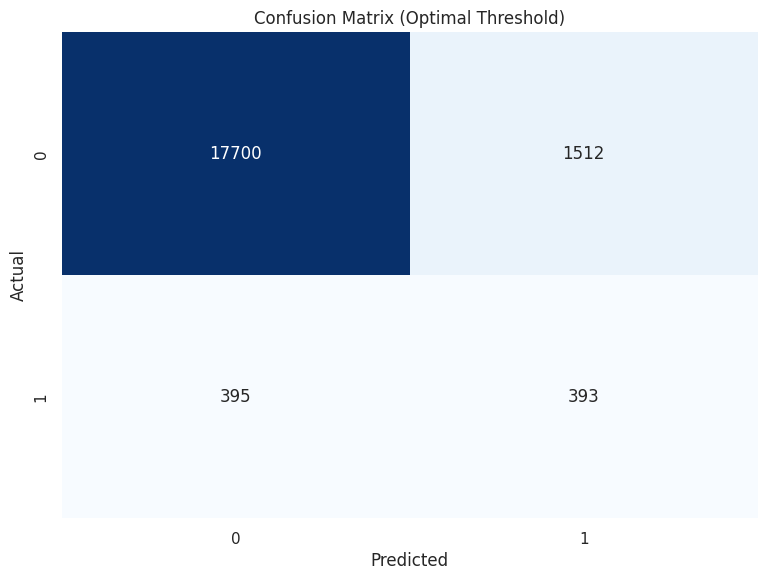


Comparison between default threshold (0.5) and optimal threshold:

Default threshold (0.5) metrics:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     19212
           1       0.12      0.88      0.21       788

    accuracy                           0.74     20000
   macro avg       0.56      0.81      0.53     20000
weighted avg       0.96      0.74      0.82     20000


Optimal threshold metrics:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     19212
           1       0.21      0.50      0.29       788

    accuracy                           0.90     20000
   macro avg       0.59      0.71      0.62     20000
weighted avg       0.95      0.90      0.92     20000



In [8]:
# Feature Importance of Best Model
plt.figure(figsize=(12, 6))
feature_importance_best = best_model.feature_importances_
sorted_idx_best = np.argsort(feature_importance_best)
plt.barh(np.array(X.columns)[sorted_idx_best], feature_importance_best[sorted_idx_best])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Best Model)')
plt.tight_layout()
plt.show()

# Display top 5 most important features for the best model
feature_importance_best_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 5 Most Important Features (Best Model):")
display(feature_importance_best_df.head(5))

# Additional metrics for imbalanced classification
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

# Calculate average precision
avg_precision = average_precision_score(y_test, y_pred_proba_best)
print(f"\nAverage Precision Score: {avg_precision:.4f}")

# Threshold Optimization for the best model
# Find optimal threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"F1 Score at Optimal Threshold: {f1_scores[optimal_threshold_idx]:.4f}")
print(f"Precision at Optimal Threshold: {precision[optimal_threshold_idx]:.4f}")
print(f"Recall at Optimal Threshold: {recall[optimal_threshold_idx]:.4f}")

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall[:-1], precision[:-1], 'b-', label=f'Precision-Recall curve, AvgPrecision = {avg_precision:.4f}')
plt.scatter(recall[optimal_threshold_idx], precision[optimal_threshold_idx], marker='o', color='red',
           label=f'Optimal threshold = {optimal_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Apply optimal threshold to predictions
y_pred_optimal = (y_pred_proba_best >= optimal_threshold).astype(int)

# Evaluate with optimal threshold
print("\nModel Evaluation with Optimal Threshold:")
print("Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("F1 Score:", f1_score(y_test, y_pred_optimal))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))

# Plot confusion matrix with optimal threshold
plt.figure(figsize=(8, 6))
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Optimal Threshold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compare balanced and default threshold predictions
print("\nComparison between default threshold (0.5) and optimal threshold:")
y_pred_default = (y_pred_proba_best >= 0.5).astype(int)
print("\nDefault threshold (0.5) metrics:")
print(classification_report(y_test, y_pred_default))
print("\nOptimal threshold metrics:")
print(classification_report(y_test, y_pred_optimal))

In [9]:
# Save the best model
import pickle

# Save the model
model_filename = 'JJC_heartdisease_prediction_xgboost_model.pkl'
pickle.dump(best_model, open(model_filename, 'wb'))
print(f"Best model saved to {model_filename}")

# Save the optimal threshold and imbalance information
threshold_info = {
    'optimal_threshold': optimal_threshold,
    'best_parameters': grid_search.best_params_,
    'class_imbalance_ratio': scale_pos_weight_value,
    'evaluation_metrics': {
        'accuracy': accuracy_score(y_test, y_pred_optimal),
        'f1_score': f1_score(y_test, y_pred_optimal),
        'auc': auc_best,
        'average_precision': avg_precision
    }
}
threshold_filename = 'optimal_threshold_info.pkl'
pickle.dump(threshold_info, open(threshold_filename, 'wb'))
print(f"Threshold information saved to {threshold_filename}")

# Example of how to load the model and make predictions
print("\nExample of loading the model and making predictions:")
print("-------------------------------------------------------")

# Load the model
loaded_model = pickle.load(open(model_filename, 'rb'))
loaded_threshold_info = pickle.load(open(threshold_filename, 'rb'))

# Display the loaded information
print("\nLoaded threshold information:")
print(loaded_threshold_info)

# Create a sample for prediction (using first test sample)
sample = X_test.iloc[0].values.reshape(1, -1)
print("\nSample for prediction:")
print(pd.DataFrame([X_test.iloc[0]], columns=X.columns))

# Make prediction
pred_proba = loaded_model.predict_proba(sample)[0, 1]
pred_class = 1 if pred_proba >= loaded_threshold_info['optimal_threshold'] else 0

print(f"\nPrediction probability: {pred_proba:.4f}")
print(f"Predicted class: {pred_class}")
print(f"Actual class: {y_test.iloc[0]}")

Best model saved to JJC_heartdisease_prediction_xgboost_model.pkl
Threshold information saved to optimal_threshold_info.pkl

Example of loading the model and making predictions:
-------------------------------------------------------

Loaded threshold information:
{'optimal_threshold': np.float32(0.78657556), 'best_parameters': {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 24.364616360177553, 'subsample': 0.8}, 'class_imbalance_ratio': 24.364616360177553, 'evaluation_metrics': {'accuracy': 0.90465, 'f1_score': 0.29186780542146307, 'auc': np.float64(0.8807368174079017), 'average_precision': np.float64(0.20005438129778041)}}

Sample for prediction:
       gender   age  hypertension  smoking_history    bmi  HbA1c_level  \
63132     0.0  80.0           1.0              0.0  22.93          6.6   

       blood_glucose_level  diabetes  
63132                160.0       0.0  

Prediction probability: 0.8154
Predicted cla